In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'
# do only the period 2006-2016
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time
import cartopy.io.shapereader as shpreader
matplotlib.rcParams.update({'font.size': 18})

In [2]:
#import cartopy
print(np.__version__, pd.__version__, ulmo.__version__, scipy.__version__,
      matplotlib.__version__, #cartopy.__version__
     )
import sys
print(sys.version)

('1.10.4', u'0.18.1', '0.8.3dev', '0.17.1', '1.5.1')
2.7.11 |Anaconda custom (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]


In [19]:
# functions
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
    
def color_scatter_years(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cmap = plt.cm.get_cmap('Greys_r', 7)
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = cmap)# cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[1985,1995, 2005, 2015], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985','1995', '2005', '2015'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p
def color_scatter(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[6000,16800], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985', '2016'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p

# plotting 
# define functions used for plotting 
def lin_trend_plot(start_x, y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

# statistics
def pearsonr_autocorrelated(x, y):
    """
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear
    relationship. Positive correlations imply that as x increases, so does
    y. Negative correlations imply that as x increases, y decreases.
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.
    Parameters
    ----------
    x : (N,) array_like
        Input
    y : (N,) array_like
        Input
    Returns
    -------
    (Pearson's correlation coefficient,
     2-tailed p-value)
    References
    ----------
    http://www.statsoft.com/textbook/glosp.html#Pearson%20Correlation
    """
    # x and y should have same length.
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = np.corrcoef(y[1:],y[0:-1])[0,1] #y.autocorr(1)
    n_prime = n*(1-r)/(1+r)
    mx = x.mean()
    my = y.mean()
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym)
    r_den = np.sqrt(ss(xm) * ss(ym))
    r = r_num / r_den

    # Presumably, if abs(r) > 1, then it is only some small artifact of floating
    # point arithmetic.
    r = max(min(r, 1.0), -1.0)
    df = n_prime-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r, prob

def ss(a, axis=0):
    """
    Squares each element of the input array, and returns the sum(s) of that.
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or None, optional
        The axis along which to calculate. If None, use whole array.
        Default is 0, i.e. along the first axis.
    Returns
    -------
    ss : ndarray
        The sum along the given axis for (a**2).
    See also
    --------
    square_of_sums : The square(s) of the sum(s) (the opposite of `ss`).
    Examples
    --------
    >>> from scipy import stats
    >>> a = np.array([1., 2., 5.])
    >>> stats.ss(a)
    30.0
    And calculating along an axis:
    >>> b = np.array([[1., 2., 5.], [2., 5., 6.]])
    >>> stats.ss(b, axis=1)
    array([ 30., 65.])
    """
    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

def _chk_asarray(a, axis):
    if axis is None:
        a = np.ravel(a)
        outaxis = 0
    else:
        a = np.asarray(a)
        outaxis = axis
    return a, outaxis

def betai(a, b, x):
    """
    Returns the incomplete beta function.
    I_x(a,b) = 1/B(a,b)*(Integral(0,x) of t^(a-1)(1-t)^(b-1) dt)
    where a,b>0 and B(a,b) = G(a)*G(b)/(G(a+b)) where G(a) is the gamma
    function of a.
    The standard broadcasting rules apply to a, b, and x.
    Parameters
    ----------
    a : array_like or float > 0
    b : array_like or float > 0
    x : array_like or float
        x will be clipped to be no greater than 1.0 .
    Returns
    -------
    betai : ndarray
        Incomplete beta function.
    """
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return scipy.special.betainc(a, b, x)

def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = np.array([]), cmap = matplotlib.cm.YlOrRd,  bounds = np.linspace(0,2,11)) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    # results_df[results_df['P-value']>0.05]
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = '.9'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data
    data = data[~np.isnan(data)]
    # Set up colors for plotting
    #cmap = matplotlib.cm.coolwarm
    #cmap = matplotlib.cm.YlOrRd
    c = data
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data

    ax.set_title('a) ')
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.loc[c_insignificant.index]['Urban Lon'], paired_df.loc[c_insignificant.index]['Urban Lat'], 
                #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
                    c = c[c_insignificant.index].values, s = marker_size-50, 
                   transform=ccrs.Geodetic(),edgecolors= 'None',
                   cmap = cmap, norm = norm, zorder =1)        
        sig_cities = np.setdiff1d(paired_df.index,c_insignificant.index )
        plotHandle = ax.scatter(paired_df.loc[sig_cities]['Urban Lon'], 
                                paired_df.loc[sig_cities]['Urban Lat'], 
                            c = c[sig_cities].values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    else: 
        plotHandle = ax.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.loc[c.index]['Urban Lon'].values, paired_df.loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


#     cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
#                       orientation='horizontal', shrink = .5)
#     cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.05, 0.0, 0.22, 0.25])
    #plot data
    n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, 0), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('b)')
    if data.max() < 0.1 : 
        sub_ax.set_xticks(sub_ax.get_xticks()[::2])

    # set histogram colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig, ax, sub_ax

In [5]:
#pairs = pd.read_csv('USpairs_stationlengths_stationavailability75_noairport.csv')
# pairs = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv')
# paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# paired_df = paired_df.drop(2)
# drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
# paired_df = paired_df.set_index(paired_df['City']).drop(drop_cities)

In [3]:
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City')

In [7]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city
# pre-allocate
#summertime
slopes           = np.ones(paired_df.shape[0])*np.nan
residuals        = np.ones(paired_df.shape[0])*np.nan
correlations     = np.ones(paired_df.shape[0])*np.nan
urban_start_date = np.ones(paired_df.shape[0])*np.nan
urban_end_date   = np.ones(paired_df.shape[0])*np.nan
rural_start_date = np.ones(paired_df.shape[0])*np.nan
rural_end_date   = np.ones(paired_df.shape[0])*np.nan
n_events         = np.ones(paired_df.shape[0])*np.nan
mean_rural_temp  = np.ones(paired_df.shape[0])*np.nan
mean_UHI         = np.ones(paired_df.shape[0])*np.nan
p_value          = np.ones(paired_df.shape[0])*np.nan
intercepts       = np.ones(paired_df.shape[0])*np.nan
max_UHI_day      = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend_pvalue = np.ones(paired_df.shape[0])*np.nan
urban_lin_trend = np.ones(paired_df.shape[0])*np.nan
urban_lin_trend_pvalue = np.ones(paired_df.shape[0])*np.nan
        
trend_results = np.ones([paired_df.shape[0], 10])*np.nan

#heatwave
hwslopes =np.ones(paired_df.shape[0])*np.nan
hwintercepts =np.ones(paired_df.shape[0])*np.nan
hwresiduals =np.ones(paired_df.shape[0])*np.nan
hwcorrelations =np.ones(paired_df.shape[0])*np.nan
hwp_value =np.ones(paired_df.shape[0])*np.nan
hwn_events =np.ones(paired_df.shape[0])*np.nan
hwmean_rural_temp =np.ones(paired_df.shape[0])*np.nan
hwmean_UHI =np.ones(paired_df.shape[0])*np.nan

#heatwave composite
composite_tmin = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHImin = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [4]:
results_filepath = 'plots/version5/seasonal/'
results_filename = 'US_results.csv'

In [5]:
cols = ['City', 'Slope', 'Intercepts', 'Residual','Correlation', 'P-value', 
        'Urban start date', 'Urban end date', 'Rural start date', 'Rural end date', 'Data points', 
       'Mean UHI', 'Day of Max UHI', 'Mean Seasonal Rural Temp', 
        'UHI trend', 'UHI trend p-value',
       'Urban trend', 'Urban trend p-value', 'Rural trend', 'Rural trend p-value', 
       'hw Slope', 'hw Intercepts','hw Correlation', 'hw P-value', 'hw Data points', 'hw Mean UHI', 'hw Mean Seasonal Rural Temp']
# results_df = pd.DataFrame([], columns=cols, index = paired_df.index)

#heatwave composite
composite_tmin = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)
composite_UHImin =  pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)
numhw = 150
finalhw = 50
results_filepath = 'plots/version5/seasonal/'
results_filename = 'US_results.csv'
seasons = {'mam': (3,5), 'jja': (6,8), 'son':(9,11), 'djf': (2,12)}

In [82]:
# Seasonal  UHI and temperature
# for season in ['mam', 'son', 'djf']: # loop over season. 
#create files if they don't exist
#         if ~os.path.isfile(results_filepath + season + results_filename): # check if results file exists
#             pd.DataFrame([], columns=cols, index = paired_df.index).to_csv(results_filepath + season + results_filename)
#         if ~os.path.isfile(results_filepath + season+'composite_temp.csv'): 
#             pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index).to_csv(results_filepath + season+'composite_temp.csv')
#             pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index).to_csv(results_filepath + season+'composite_UHI.csv')

for city in paired_df.index: 
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    toc = time.time() #time

    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2004-12-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2004-12-01':].value/10.) 
    # clean data: eliminate data with flags     
    rural_tmin[~ruraldata['TMIN']['qflag'].isnull()] = np.nan
    urban_tmin[~urbandata['TMIN']['qflag'].isnull()] = np.nan
    for season in ['mam', 'son', 'djf']: # loop over season. Note that this is super inefficient- should be inside city loop, but no time to code.
        #heatwave composite
        print(season)
        start_month, end_month = seasons[season]
        if season == 'djf': 
            rural_summer = rural_tmin[(rural_tmin.index.month >= end_month)].append(rural_tmin[(rural_tmin.index.month <= start_month)])
            urban_summer = urban_tmin[(urban_tmin.index.month >= end_month)].append(urban_tmin[(urban_tmin.index.month <= start_month)])
        else: 
        # extract summertime data 
            rural_summer = rural_tmin[(rural_tmin.index.month >= start_month) & (rural_tmin.index.month <= end_month)]
            urban_summer = urban_tmin[(urban_tmin.index.month >= start_month) & (urban_tmin.index.month <= end_month)]

        #calculate UHI
        UHI = urban_summer - rural_summer

        ######
        ###### Calculate UHI statistics
        ###### 
        x = rural_summer
        y = UHI
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs

        slope, intercept, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
        C = pearsonr_autocorrelated(x[ind], y[ind])
    #         results_df.loc[city][['City', 'Slope', 'Intercepts', 'Residual','Correlation', 'P-value', ]] = city, C[1], intercept, std_err, r_value, p
    #         results_df.loc[city][['Mean UHI', 'Mean Seasonal Rural Temp']] = y[ind].mean(), x[ind].mean()
        results_df.loc[city][[ 'Slope', 'Intercepts', 'Residual','Correlation', 'P-value', ]] = slope, intercept, std_err, C[0], C[1]

        ######
        ###### Calculate heatwaves
        ######        
        hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 

        #heatwaves
        hw_x = rural_summer[hottestmin.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        hw_y = UHI[hottestmin.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        hw_ind = ~np.isnan(hw_y) & ~np.isnan(hw_x) # subset values that aren't NaNs
        hwm, hwb = np.polyfit(hw_x[hw_ind],hw_y[hw_ind],1)
        hwr, hwp = scipy.stats.pearsonr(hw_x[hw_ind],hw_y[hw_ind])
        
        results_df.loc[city][['hw Slope', 'hw Intercepts','hw Correlation', 'hw P-value', 'hw Data points']] = hwm, hwb, hwr, hwp, hw_ind.values.sum()
        results_df.loc[city][['hw Mean UHI', 'hw Mean Seasonal Rural Temp']] = hw_y.mean(), hw_x.mean()

        minheatwaves = hottestmin[0:12]
        ### make sure that heatwaves aren't duplicates
        Ns = []
        m = 0 
        for n in range(1,10): 
            old = m
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                minheatwaves = hottestmin[0:20]
                try: 
                    while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                        m = m+1
                except IndexError: 
                    print('out of bounds')
            try: 
                if old ==m : 
                    Ns.append(minheatwaves.sort_index().index[m])
                else: 
                    Ns.append(minheatwaves.sort_index()[old:m].argmax())
            except: 
                'random error'
            m = m+1
        finalhw = hottestmin[Ns].sort_values(ascending=False)


        # calculate composite heatwaves
        heatwaves = finalhw
        compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
        compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
        ii = 0
        for dates in heatwaves.index[:]: 
            compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
            ii = ii+1
        composite_tmin.loc[city] = np.nanmean(compositeTemp, axis=0)
        composite_UHImin.loc[city] = np.nanmean(compositeUHI, axis=0)

        ######
        ###### Calculate trends
        ######
        # calculate rural trends
        #try:
        y = rural_summer.groupby(rural_summer.index.year).mean()
        ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
        x = np.arange(0,y.shape[0])
        slopeT, interceptT, r_valueT, pT, std_errT  = scipy.stats.linregress(x[ind],y[ind])
        # calculate urban trends
        y = urban_summer.groupby(urban_summer.index.year).mean()
        ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
        x = np.arange(0,y.shape[0])
        slopeU, interceptU, r_valueU, pU, std_errU  = scipy.stats.linregress(x[ind],y[ind])
        # calculate UHI trends
        y = UHI.groupby(UHI.index.year).mean()
        ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
        x = np.arange(0,y.shape[0])
        slope, intercept, r_value, p, std_err  = scipy.stats.linregress(x[ind],y[ind])
        
        results_df.loc[city][['UHI trend', 'UHI trend p-value','Urban trend', 'Urban trend p-value', 'Rural trend', 'Rural trend p-value']] = [slope, p, slopeT, pT, slopeU, pU]


        ######
        ###### Save out data
        ######
        # read in the correct season's results
        results_df = pd.read_csv(results_filepath + season + results_filename).set_index('City')
        composite_tmin = pd.read_csv(results_filepath + season+'composite_temp.csv').set_index('City')
        composite_UHImin = pd.read_csv(results_filepath + season+'composite_UHI.csv').set_index('City')

        #save out mean temp and other stats
        #results_df.loc[city][['Mean UHI', 'Mean Seasonal Rural Temp']] = y[ind].mean(), x[ind].mean()

        results_df.loc[city][['Rural start date', 'Rural end date']] = [rural_tmin[~np.isnan(rural_tmin)].index[0].year, rural_tmin[~np.isnan(rural_tmin)].index[-1].year ]
        results_df.loc[city][['Urban start date', 'Urban end date']] = [urban_tmin[~np.isnan(urban_tmin)].index[0].year, urban_tmin[~np.isnan(urban_tmin)].index[-1].year ]
        results_df.loc[city][['Mean UHI', 'Day of Max UHI','Mean Seasonal Rural Temp']] = UHI.mean(), UHI.groupby(UHI.index.day_of_year).mean().argmax(), rural_summer.mean()
        # save out hw results
#         results_df.loc[city][['hw Slope', 'hw Intercepts','hw Correlation', 'hw P-value', 'hw Data points']] = hwm, hwb, hwr, hwp, hw_ind.values.sum()
#         results_df.loc[city][['hw Mean UHI', 'hw Mean Seasonal Rural Temp']] = hw_y.mean(), hw_x.mean()
        # save out trend results
        results_df.to_csv(results_filepath + season + results_filename)
        composite_tmin.to_csv(results_filepath + season+'composite_temp.csv')
        composite_UHImin.to_csv(results_filepath + season+'composite_UHI.csv')

tic = time.time()
print('Elapsed time: ', tic-toc)

Birmingham
mam
son
djf
out of bounds
St. Petersburg
mam
son
djf
Virginia Beach
mam
son
djf
Oakland
mam
son
djf
out of bounds
out of bounds
out of bounds
West Palm Beach
mam
son
djf
out of bounds
Louisville
mam
son
out of bounds
out of bounds
djf
Charlotte
mam
son
djf
out of bounds
out of bounds
out of bounds
Columbus
mam
son
djf
San Bernardino
mam
son
djf
St. Paul
mam
son
djf
Tucson
mam
out of bounds
son
djf
Fresno
mam
son
djf
Albuquerque
mam
son
out of bounds
djf
Kansas City
mam
son
out of bounds
out of bounds
out of bounds
djf
Tulsa
mam
son
djf
Ft. Worth
mam
son
djf
Austin
mam
son
djf
El Paso
mam
son
djf
out of bounds
Orlando
mam
son
djf
Jacksonville
mam
out of bounds
son
djf
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Indianapolis
mam
son
djf
Richmond
mam
son
djf
Baltimore
mam
son
djf
San Jose
mam
son
djf
Sacramento
mam
son
out of bounds
djf
Las Vegas
mam
son
djf
Portland
mam
son
djf
Salt Lake City
mam
son
djf
Omaha
mam
son
out of bounds
out of bounds
djf
O

In [22]:
#results_filepath = 'plots/version5/seasonal/'
results_filepath = 'plots/version6/'
results_filename = 'US_results_cleaned_data.csv'

In [23]:
ls plots/version6

US_results_cleaned_data.csv     figure3.eps
anomalyJJAslopes.pdf            figure4.eps
avg_hw_map.pdf                  figure5.eps
compositetrural.csv             figureS1.eps
compositetuhi.csv               figureS2.eps
compositeturban.csv             figureS7.eps
djfUS_results_cleaned_data.csv  hwcompositeTMIN.pdf
errorbars/                      mamUS_results_cleaned_data.csv
extreme_hw_map.pdf              mean_UHI.pdf
figure01.pdf                    slope_boxplot.pdf
figure03_15years.pdf            sonUS_results_cleaned_data.csv
figure04.pdf                    ssc/
figure1.eps                     summer_mean_slopes.pdf
figure2a_2d.eps                 synopticwxTuTr.pdf
figure2e_2f.eps                 tmax/


In [63]:
rural_summer.mean()

12.051434034416832

In [12]:
seasons.keys()

['djf', 'mam', 'jja', 'son']

In [24]:
djf_df = pd.read_csv(results_filepath+'djf' +results_filename).set_index('City', drop = False)
mam_df = pd.read_csv(results_filepath+'mam' +results_filename).set_index('City', drop = False)
son_df = pd.read_csv(results_filepath+'son' +results_filename).set_index('City', drop = False)

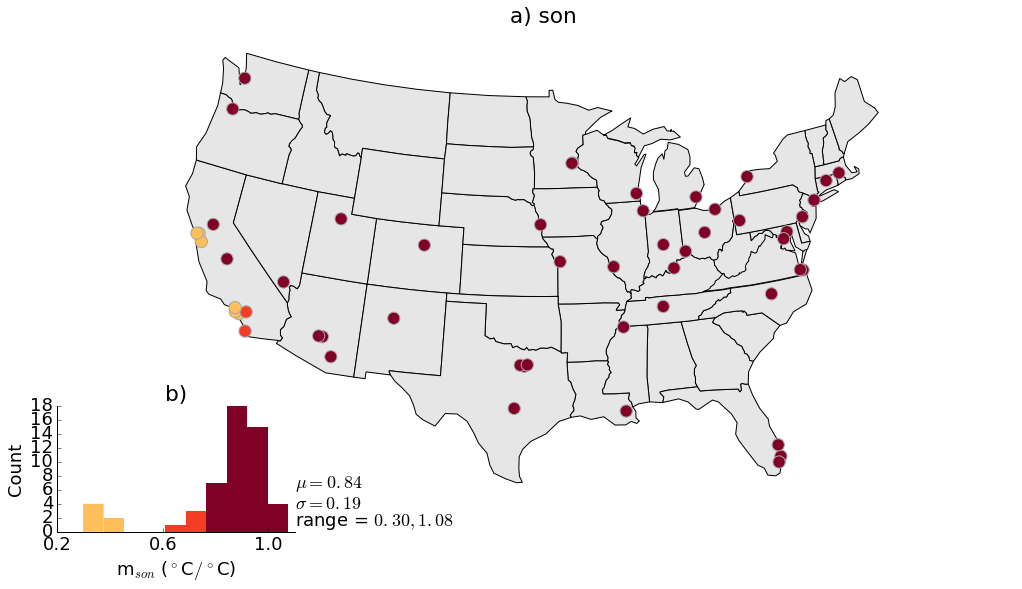

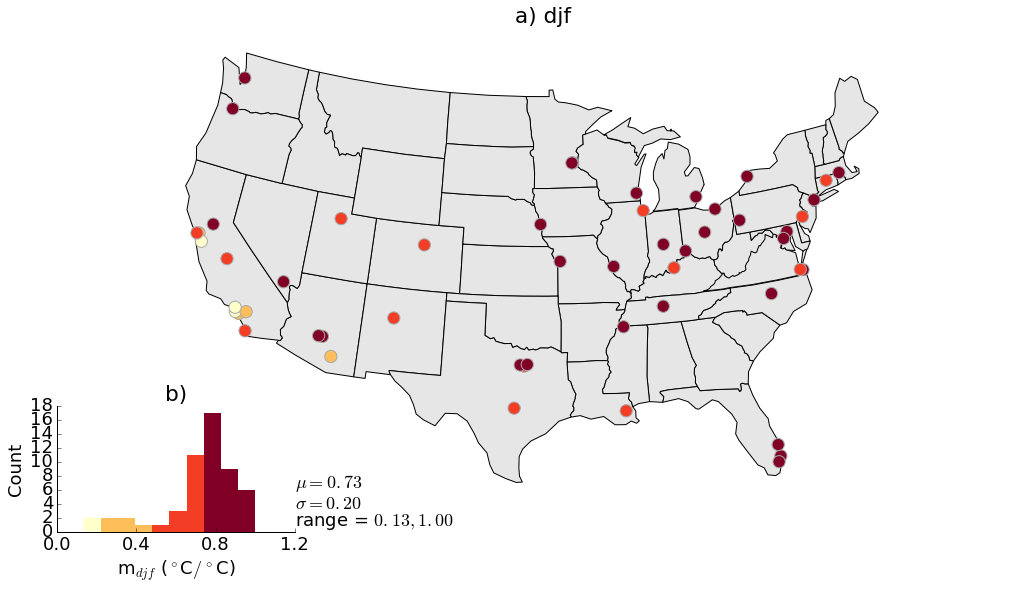

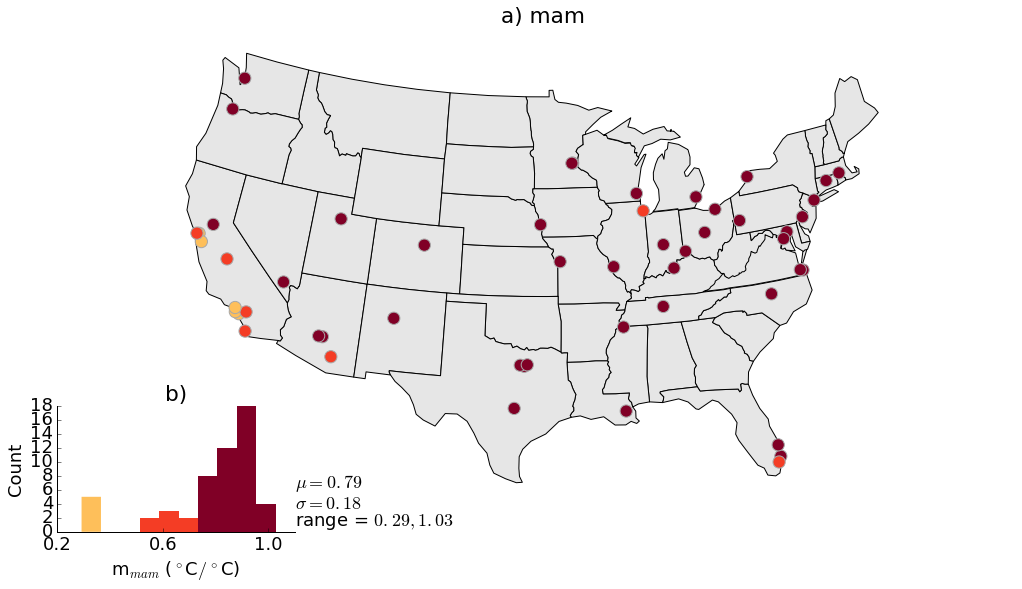

In [28]:
# Figure 1 seasonal 
#data = results_df['Slope']#.drop(drop_cities, axis = 0)['Slope'] #slopes
i = 4;
for season, data in zip(['son','djf',  'mam'], [ son_df['slope'],djf_df['slope'], mam_df['slope']]): 
    fig, ax, sub_ax = map_hist_plot(data, paired_df,
                    cmap = matplotlib.cm.YlOrRd, bounds = np.linspace(0,1,5)) 
    ax.set_title(ax.get_title() + season )#+ ' sensitivity of $\Delta T$ to $T_r$')
    sub_ax.set_xticks(sub_ax.get_xticks()[::2])
    sub_ax.set_xlabel('m$_{%s}$ ($^\circ$C$ / ^\circ $C)'%season)
    plt.savefig(results_filepath+ season + 'slopes.pdf', bbox_inches='tight')
    plt.savefig(results_filepath+'figureS%i.eps'%i, bbox_inches='tight')
    i = i+1

In [ ]:
# Figure 2
plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in heatwaves.index: 
    if ~np.isnan(compositeUHI[i][10]): 
        if i ==0 : 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-1.7, 'Composite Mean', color = 'black')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Phoenix'][4],'Phoenix', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

# Heatwave map
# note: c_insignificant = results_df[results_df['hw P-value']>0.05] but this data seems to not be saved? check older versions of file
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['hw Slope']#.drop(drop_cities) #slopes

fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Average Heatwaves',# ''$\Delta T$ sensitivity to average heatwaves temp. change', 
                    data_label='m$_{hw}$ ($^\circ$C/$^\circ$C)', 
                   c_insignificant = results_df[results_df['hw P-value']>0.05]) 
ax.set_title('e)')
sub_ax.set_title('f)')
plt.savefig(results_filepath+ 'avghwslopemap.pdf', bbox_inches='tight')

0.00311364930437
0.000942477512313
0.0110812877855


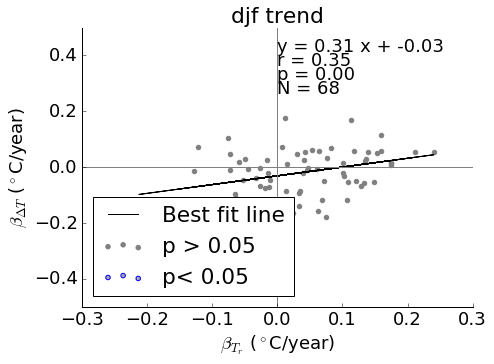

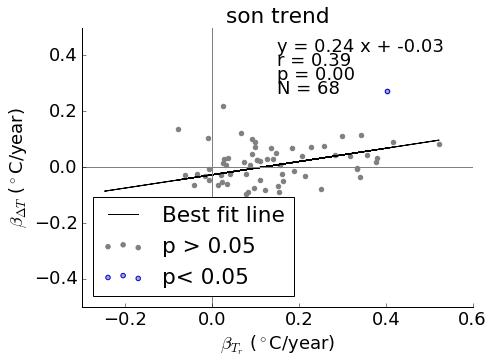

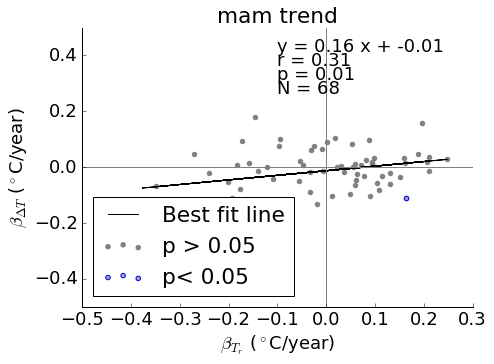

In [102]:
# Figure 3 
for season, data in zip(['djf', 'son', 'mam'], [djf_df, son_df, mam_df]): 
    x = data['Rural trend']
    y =  data['UHI trend']
    plt.figure(figsize=[7,5])
#     plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
#                  color = 'DarkGray', zorder =0)

    m, r, p = hw_scatter(x,y,
               '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
               r'$\beta_{\Delta T}$ ($^\circ$C/year)')

    plt.scatter(data[(data['Rural trend p-value'] < .05) & (data['UHI trend p-value']<.05)]['Rural trend'], 
               data[(data['Rural trend p-value'] < .05) & (data['UHI trend p-value']<.05)]['UHI trend'], 
               color = 'darkgray', edgecolor = 'blue', zorder =1)

    plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)
    plt.title(season + ' trend')
    plt.axhline(0, color = 'gray')
    plt.axvline(0, color = 'gray')
    plt.ylim([-0.5,.5])
    prettify_plot()
    plt.savefig(results_filepath+season+'30yeartrend.pdf', bbox_inches='tight')
    print(p)

0.0650476147718
0.000159753535544
0.00107506480814


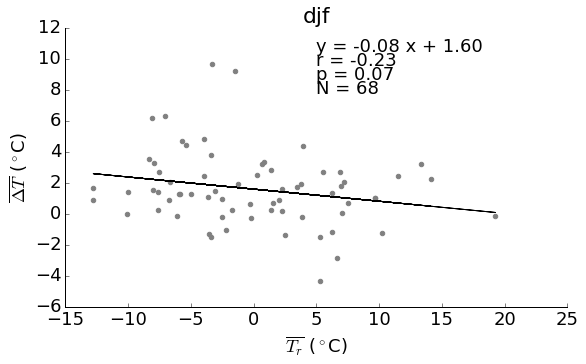

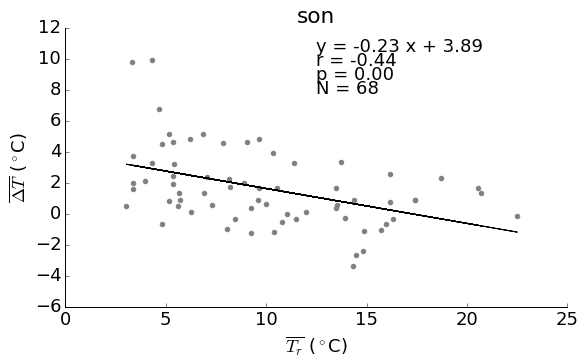

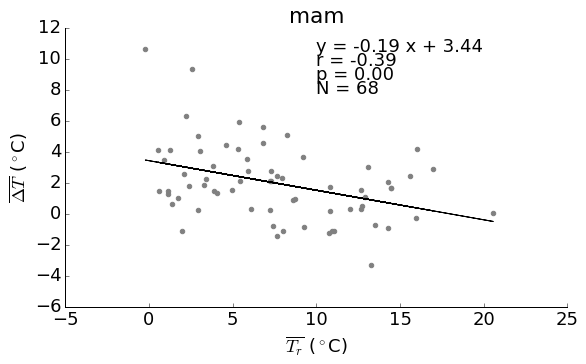

In [105]:
# Figure 4: spatial variability, or, do hotter cities have less intense UHIs?
for season, results_df in zip(['djf', 'son', 'mam'], [djf_df, son_df, mam_df]): 
    plt.figure(figsize=[9,5])
    x = results_df['Mean Seasonal Rural Temp']
    y = results_df['Mean UHI']
    #plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
    m,r,p = hw_scatter(x,y,
                 '%s'%season, 
                 '$\overline{T_r}$ ($^\circ$C)', '$\overline{\Delta T}$ ($^\circ$C)')
    prettify_plot()
    plt.savefig(results_filepath+season+'meantempvsmeanUHI.pdf',bbox_inches='tight')
    print(p)

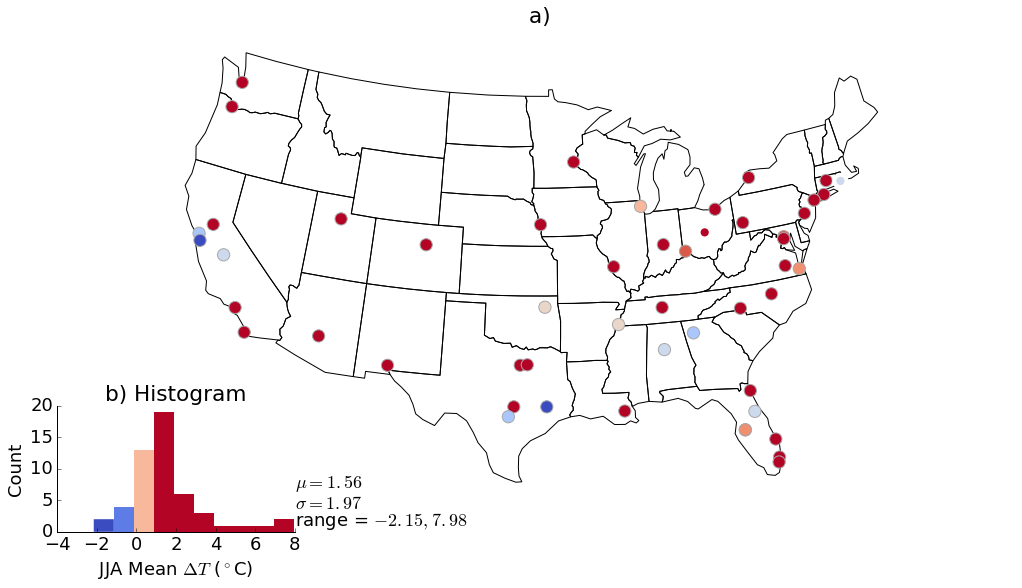

In [85]:
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['Mean UHI']#.drop(drop_cities, axis = 0)
fig = map_hist_plot(data, paired_df, title = 'Mean UHI', 
                    data_label = 'JJA Mean $\Delta T$ ($^\circ$C)', 
                   c_insignificant = results_df[results_df['P-value']>0.05]) 
plt.savefig(results_filepath+ 'meanUHI.pdf', bbox_inches='tight')

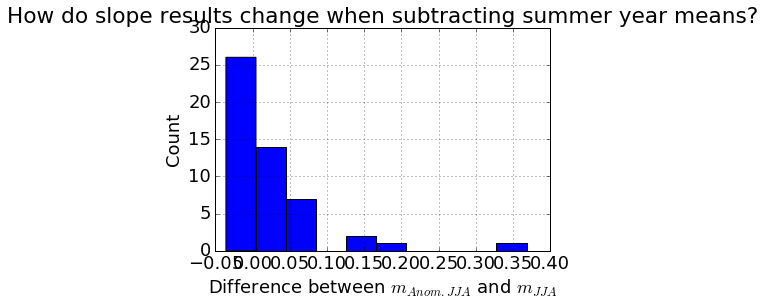

In [94]:
anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv').set_index(paired_df['City'])
(anomaly_results['Anomaly m']- results_df['Slope']).hist()
plt.ylabel('Count')
plt.xlabel('Difference between $m_{Anom. JJA}$ and $m_{JJA}$')
plt.title('How do slope results change when subtracting summer year means?')

/Users/annascott2/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


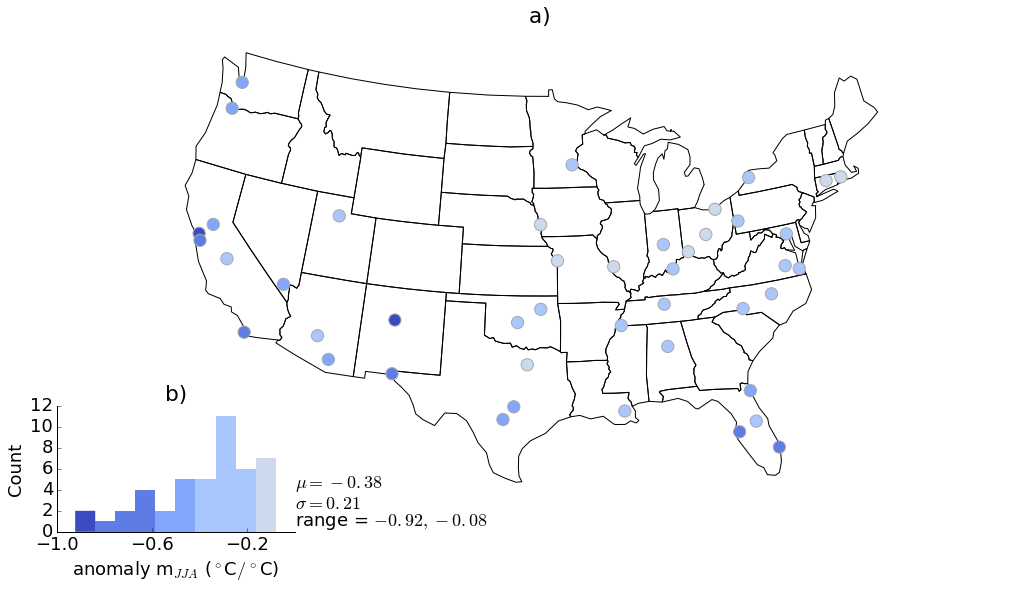

In [102]:
data = anomaly_results['Anomaly m']#.drop(drop_cities, axis = 0)['Anomaly m']
fig = map_hist_plot(data, paired_df, title = 'Response of Anomaly $\Delta T$ to Temperature Change', 
                    data_label = 'anomaly m$_{JJA}$ ($^\circ$C$ / ^\circ $C)', 
                   c_insignificant = anomaly_results[anomaly_results['Anomaly p']>0.05]) 
plt.savefig(results_filepath+ 'anomalyJJAslopes.pdf', bbox_inches='tight')

In [7]:
results_df = pd.read_csv(results_filepath + results_filename).drop(1).set_index('City')
results_df = results_df[results_df['Data points']>0]

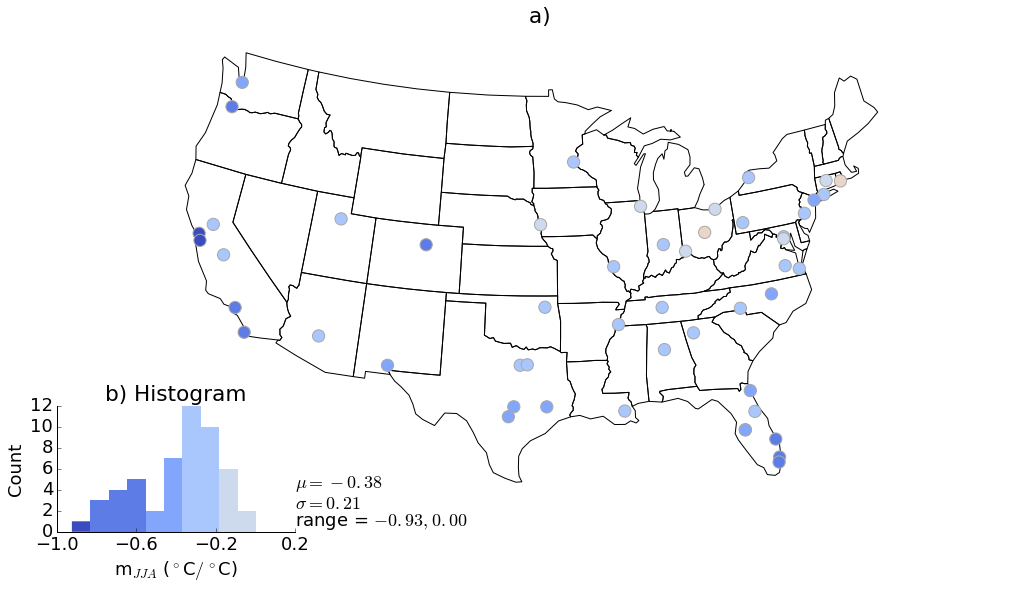

In [37]:
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['Slope']#.drop(drop_cities, axis = 0)['Slope'] #slopes

fig = map_hist_plot(data, paired_df) 
plt.savefig(results_filepath+ 'JJAslopes.pdf', bbox_inches='tight')

Baltimore
Orlando


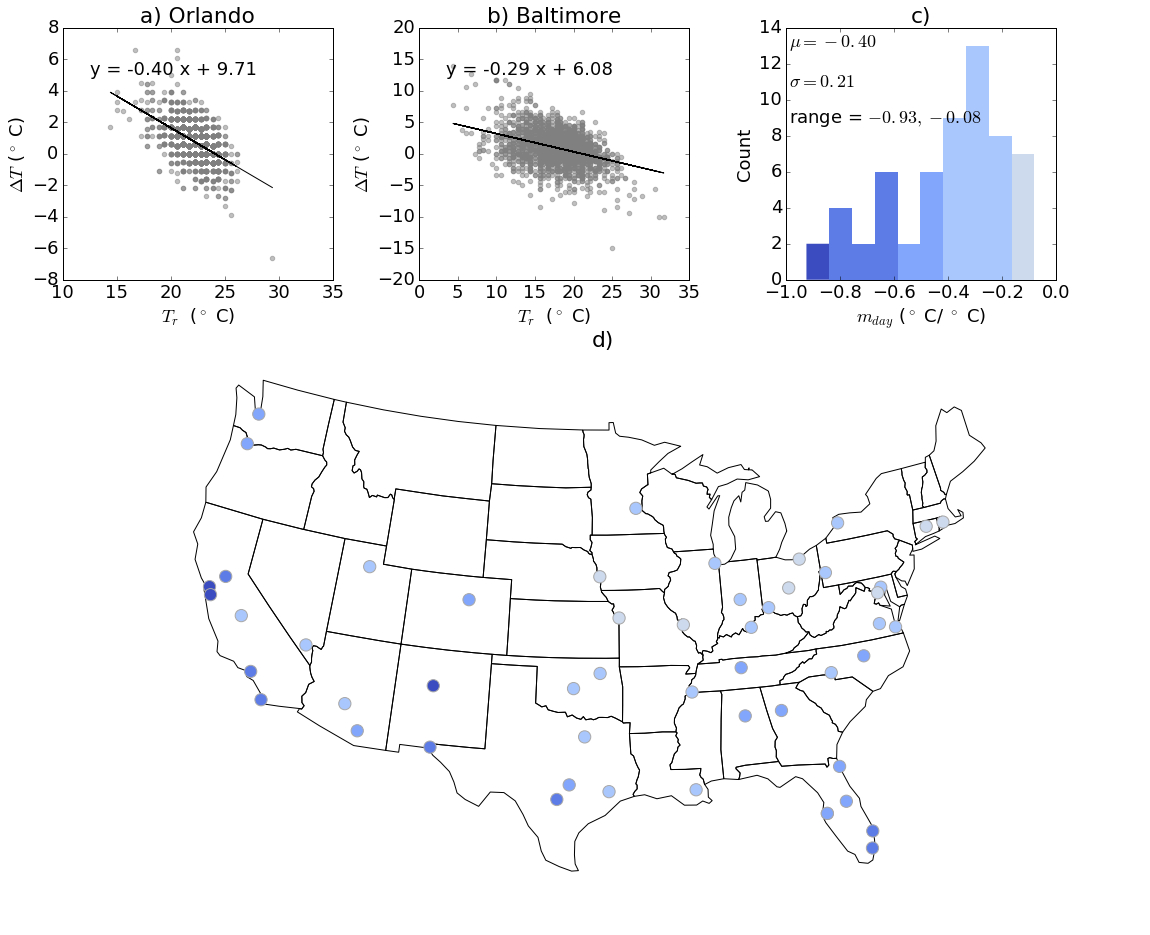

In [155]:
### map plot

def inset_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey', alpha = .5)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

fig = plt.figure(figsize=[15,10])
#ax = fig.add_subplot(224, projection=ccrs.LambertConformal())
ax = plt.axes([0, 0, 1, 1],
                    projection=ccrs.LambertConformal())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# define data
data = results_df['Slope']
data = data[~np.isnan(data)]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.title('d)')

######
dummy_ind = 0
#for i in [15, 19]: 
for city in ['Baltimore', 'Orlando']:
    # = paired_df.loc[i]['City']
    #city = unicode(city, errors = 'ignore')
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.)         
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
    # clean data: eliminate min temperatures below 4 or above 35
    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer
    if dummy_ind ==0 : 
        #sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])
        sub_ax2 = plt.axes([0.33, 1.0, 0.25, 0.35])

        #sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
        inset_scatter(rural_summer[UHI.index], UHI,'b) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
    else: 
        sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])

        #sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
        inset_scatter(rural_summer[UHI.index], UHI,'a) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
    ##### Inset plot     
    dummy_ind = dummy_ind+1
    


sub_ax = plt.axes([0.67, 1.0, 0.25, 0.35])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('c)')

# set colors 
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []

bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
plt.savefig(results_filepath+ 'fullJJAslopes.pdf', bbox_inches='tight')

In [26]:
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
UHI_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        UHI_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)
        
# drop #2- it's a duplicate
#del UHI_std[1]

In [27]:
len(UHI_std)

53

1.11051397143e-05


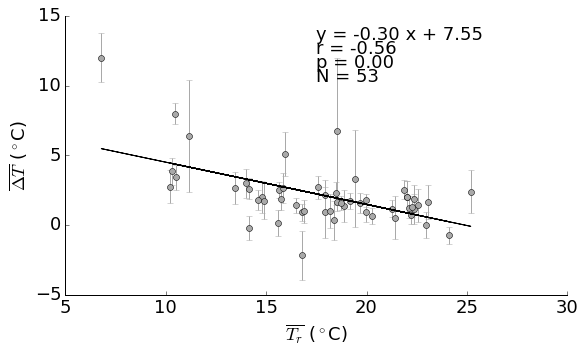

In [46]:
# hw_scatter(results_df['Mean JJA Rural Temp'],results_df['Mean UHI'],
#              'Do hotter cities have higher $\Delta T$?', 
#              '$T_r$ ($^\circ$C)', '$\overline{\Delta T}$ ($\Delta ^\circ$C)')
plt.figure(figsize=[9,5])
x = results_df['Mean JJA Rural Temp']
y = results_df['Mean UHI']
plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
m,r,p = hw_scatter(x,y,
             '', 
             '$\overline{T_r}$ ($^\circ$C)', '$\overline{\Delta T}$ ($^\circ$C)')
prettify_plot()
plt.savefig(results_filepath+ 'meantempvsmeanUHI.pdf',bbox_inches='tight')
print(p)

In [51]:
results_df['hw Correlation'].describe()

count    52.000000
mean     -0.372430
std       0.216515
min      -0.834371
25%      -0.522048
50%      -0.365787
75%      -0.232947
max       0.130977
Name: hw Correlation, dtype: float64

#### results_df[results_df['hw P-value']<0.05]['hw Slope'].describe()

In [33]:
results_df.drop(drop_cities, axis = 0)['hw Slope'].describe()

count    53.000000
mean     -0.931084
std       0.625705
min      -2.098968
25%      -1.310920
50%      -0.992990
75%      -0.571744
max       0.680402
Name: hw Slope, dtype: float64

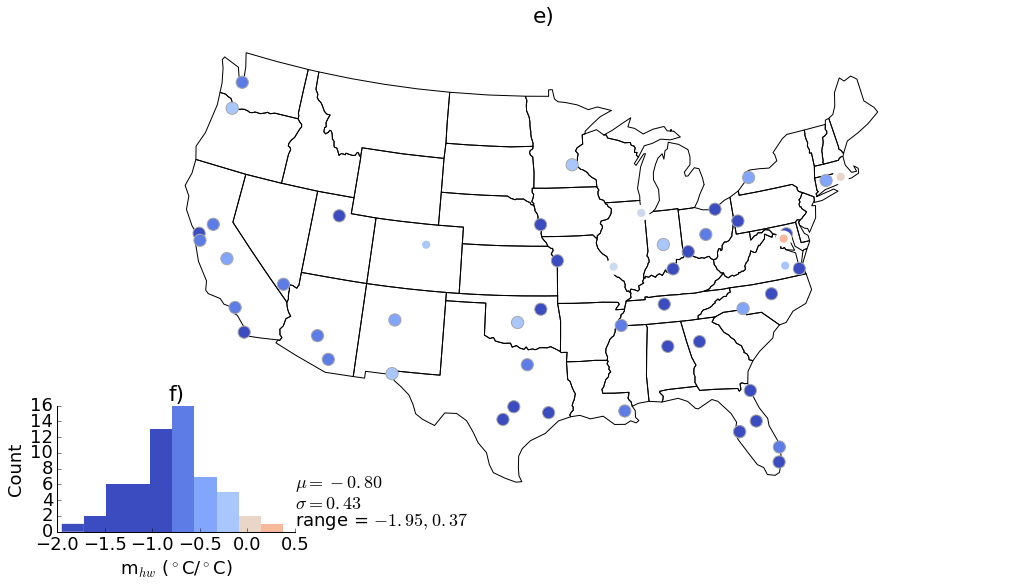

In [143]:
# Heatwave map
# note: c_insignificant = results_df[results_df['hw P-value']>0.05] but this data seems to not be saved? check older versions of file
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['hw Slope']#.drop(drop_cities) #slopes

fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Average Heatwaves',# ''$\Delta T$ sensitivity to average heatwaves temp. change', 
                    data_label='m$_{hw}$ ($^\circ$C/$^\circ$C)', 
                   c_insignificant = results_df[results_df['hw P-value']>0.05]) 
ax.set_title('e)')
sub_ax.set_title('f)')
plt.savefig(results_filepath+ 'avghwslopemap.pdf', bbox_inches='tight')

In [541]:
mean_summer_tvsdt.columns

Index([u'Unnamed: 0', u'm', u'r', u'p-value'], dtype='object')

In [452]:
mean_summer_tvsdt.loc['Washington, D.C.']

Unnamed: 0    57.000000
m             -0.283249
r             -0.168241
p-value        0.365621
Name: Washington, D.C., dtype: float64

In [451]:
mean_summer_tvsdt.loc['Baltimore']

Unnamed: 0    25.000000
m             -0.508793
r             -0.587960
p-value        0.000634
Name: Baltimore, dtype: float64

In [287]:
# change over time: summer annual temps
mean_summer_tvsdt = pd.read_csv('plots/version2/'+'summermeans/'+'mean_summer_tvsdt_results.csv').drop(2).set_index(paired_df.City)

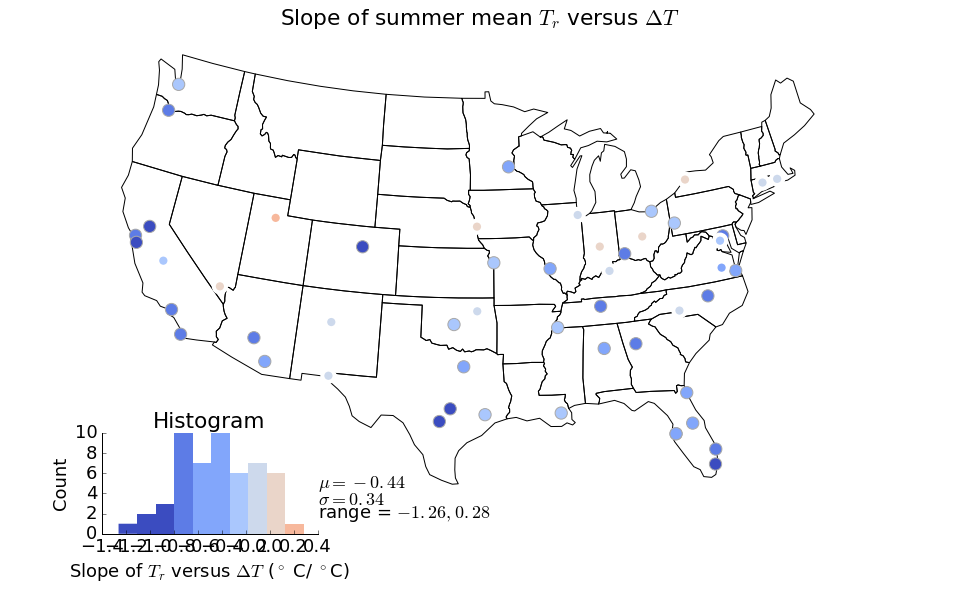

In [288]:
# change over time: summer annual temps versus UHI
mean_summer_tvsdt = pd.read_csv('plots/version2/'+'summermeans/'+'mean_summer_tvsdt_results.csv').drop(2).set_index(paired_df.City)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
fig = map_hist_plot(data, paired_df, title = 'Slope of summer mean $T_r$ versus $\Delta T$', 
                    data_label='Slope of $T_r$ versus $\Delta T$ ($^\circ$ C/ $^\circ $C)', 
                  c_insignificant = mean_summer_tvsdt[mean_summer_tvsdt['p-value']>0.05]) 
plt.savefig(results_filepath+ 'mean_summer_tvsdt_map.pdf', bbox_inches='tight')

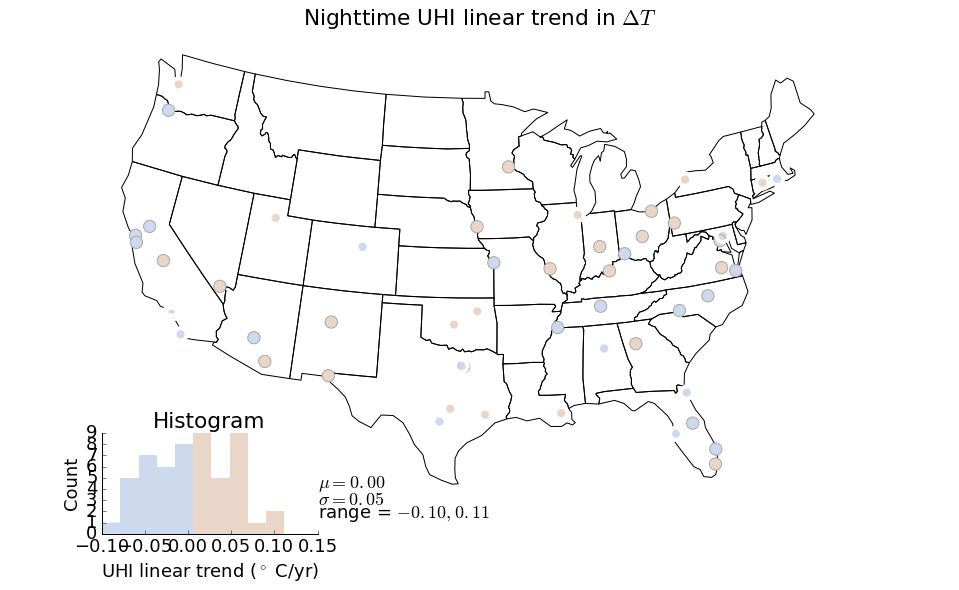

In [289]:
# linear trend in UHI
# check units- not sure if this is per year
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
data = results_df.drop(drop_cities)['UHI linear trend']

fig = map_hist_plot(data, paired_df, title = 'Nighttime UHI linear trend in $\Delta T$', 
                    data_label='UHI linear trend ($^\circ$ C/yr)', 
                  c_insignificant = results_df[results_df['UHI linear trend p-value']>0.05]) 
plt.savefig(results_filepath+ 'UHIlineartrend.pdf', bbox_inches='tight')

In [65]:
results_df.drop(drop_cities)['UHI linear trend'].mean()

0.004346023919132114

In [102]:
# percentage of warming cities
print((results_df.drop(drop_cities)['UHI linear trend'] > 0).sum()/ float(results_df.drop(drop_cities).shape[0]))
print((results_df.drop(drop_cities)['UHI linear trend'] > 0).sum())

0.528301886792
28


In [104]:
# percentage of cooling cities
print((results_df.drop(drop_cities)['UHI linear trend'] < 0).sum()/ float(results_df.drop(drop_cities).shape[0]))
print((results_df.drop(drop_cities)['UHI linear trend'] < 0).sum())

0.471698113208
25


In [53]:
results_filepath

'plots/version3/'

In [50]:
trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv').drop(2).set_index(pairs.drop(2)['City']).drop(drop_cities)

In [51]:
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
slopes_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        slopes_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)
        
# resize: 1 & 2 are the same
#slopes_std
# drop #2- it's a duplicate
#del slopes_std[1]

In [52]:
trend_resultDF['Annual UHI Slope'].mean()

0.004346023919132114

In [48]:
x.shape, y.shape, len(slopes_std)

((53,), (53,), 53)

3.95573305242e-09


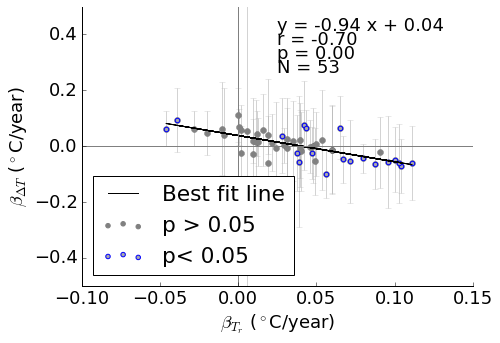

In [75]:
x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
             color = 'DarkGray', zorder =0)

m, r, p = hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf', bbox_inches='tight')
print(p)

In [198]:
trend_resultDF['Annual Temp Slope'].describe()

count    53.000000
mean      0.035613
std       0.036743
min      -0.046287
25%       0.011031
50%       0.037478
75%       0.056343
max       0.111238
Name: Annual Temp Slope, dtype: float64

In [225]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw P-value', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [226]:
pd.read_csv('plots/version3/30yrtrend/trend_results.csv')['Annual UHI Slope'].describe()

count    59.000000
mean      0.000315
std       0.053060
min      -0.169198
25%      -0.035527
50%       0.000644
75%       0.041855
max       0.111211
Name: Annual UHI Slope, dtype: float64

In [199]:
trend_resultDF['Annual UHI Slope'].describe()

count    53.000000
mean      0.004346
std       0.048908
min      -0.099377
25%      -0.027453
50%       0.002383
75%       0.044496
max       0.111211
Name: Annual UHI Slope, dtype: float64

In [213]:
trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].shape

(19, 11)

In [205]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw P-value', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [207]:
results_df.drop(drop_cities)['UHI linear trend'].describe()

count    53.000000
mean      0.004346
std       0.048908
min      -0.099377
25%      -0.027453
50%       0.002383
75%       0.044496
max       0.111211
Name: UHI linear trend, dtype: float64

In [197]:
# number of cities experiencing warming
print((trend_resultDF['Annual Temp Slope']>0).sum(), ' out of ', trend_resultDF.shape[0])
print('or ',  100*(trend_resultDF['Annual Temp Slope']>0).sum()/ float(trend_resultDF.shape[0]), ' percent')

(46, ' out of ', 53)
('or ', 86.79245283018868, ' percent')


In [215]:
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] < 0).sum()

25

In [216]:
## cooling cities
(trend_resultDF['Annual Temp Slope']<0).sum()

7

In [210]:
print((trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum())

7


In [211]:
# number of points which don't fit the story: warming but UHI increasing
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).sum()

21

In [212]:
# how many of the insignificant cities are ones in which our story doesn't fit? 
insig_index = trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].index
not_fit_index = (trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).index
np.intersect1d(insig_index, not_fit_index).shape

(17,)

In [217]:
# how many cooling cities have increased UHI
(trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum()

7

In [330]:
trend_resultDF['Annual Temp Slope'].describe()

count    58.000000
mean      0.036885
std       0.041853
min      -0.047103
25%       0.006567
50%       0.033759
75%       0.059268
max       0.134933
Name: Annual Temp Slope, dtype: float64

In [331]:
trend_resultDF['Annual UHI Slope'].describe()

count    58.000000
mean      0.000152
std       0.053657
min      -0.168602
25%      -0.039665
50%       0.000293
75%       0.042268
max       0.108919
Name: Annual UHI Slope, dtype: float64

In [46]:
cols.shape

(11,)

In [80]:
cols = np.arange(-5,6)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
composite_cities = pd.read_csv(results_filepath + results_filename)['City']

compositeTempDF = pd.read_csv((results_filepath + 'composite_temp.csv'), header = None, names =  cols).set_index(composite_cities).loc[results_df.index]#.drop(drop_cities, axis = 0)
compositeUHIDF = pd.read_csv((results_filepath + 'composite_UHI.csv'), header = None, names =  cols).set_index(composite_cities).loc[results_df.index]#.drop(drop_cities, axis = 0)

In [138]:
results_filepath

'plots/version3/'

In [82]:
compositeTempDF.shape, compositeUHIDF.shape

((53, 11), (53, 11))

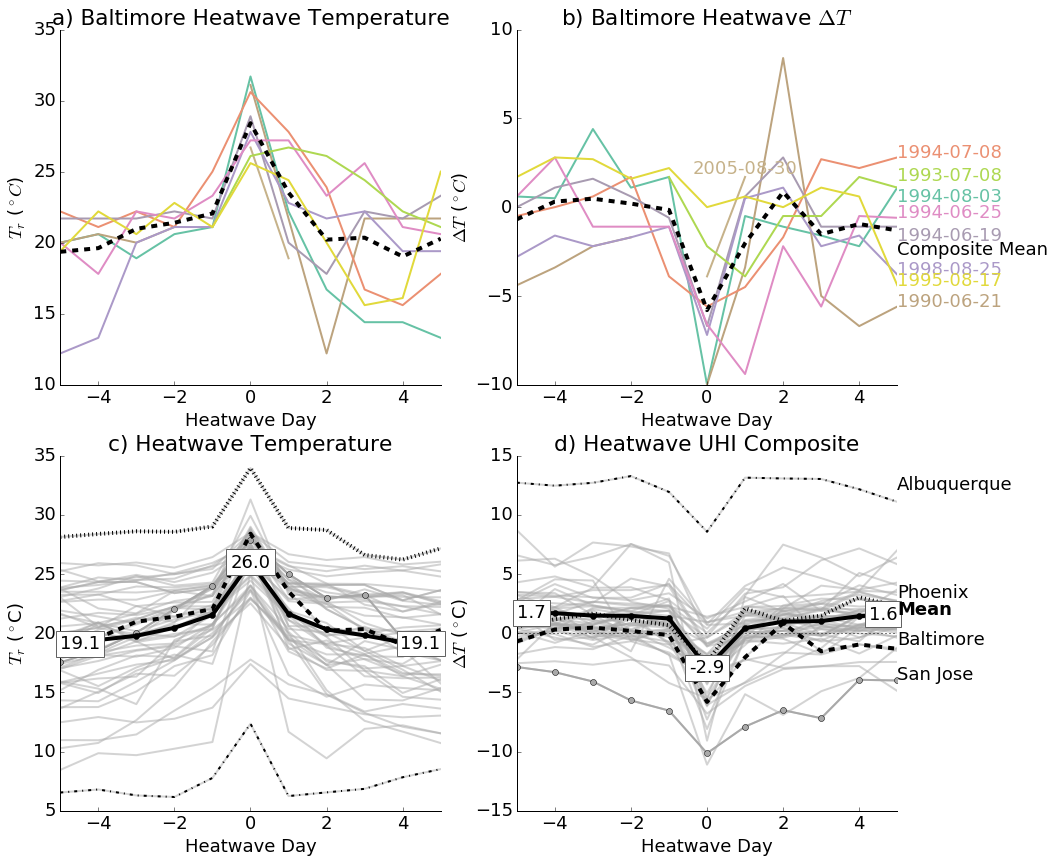

In [88]:
plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in heatwaves.index: 
    if ~np.isnan(compositeUHI[i][10]): 
        if i ==0 : 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-1.7, 'Composite Mean', color = 'black')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Phoenix'][4],'Phoenix', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

In [159]:
# sufficient to reduce $\Delta T$ to below zero on heatwave day 0 in all but 10 cities (47/52)....
compositeUHIDF[0][compositeUHIDF[0] >0 ].shape

(9,)

In [160]:
compositeTempDF.shape

(53, 11)

In [161]:
paired_df.shape

(53, 14)

In [441]:
i

9

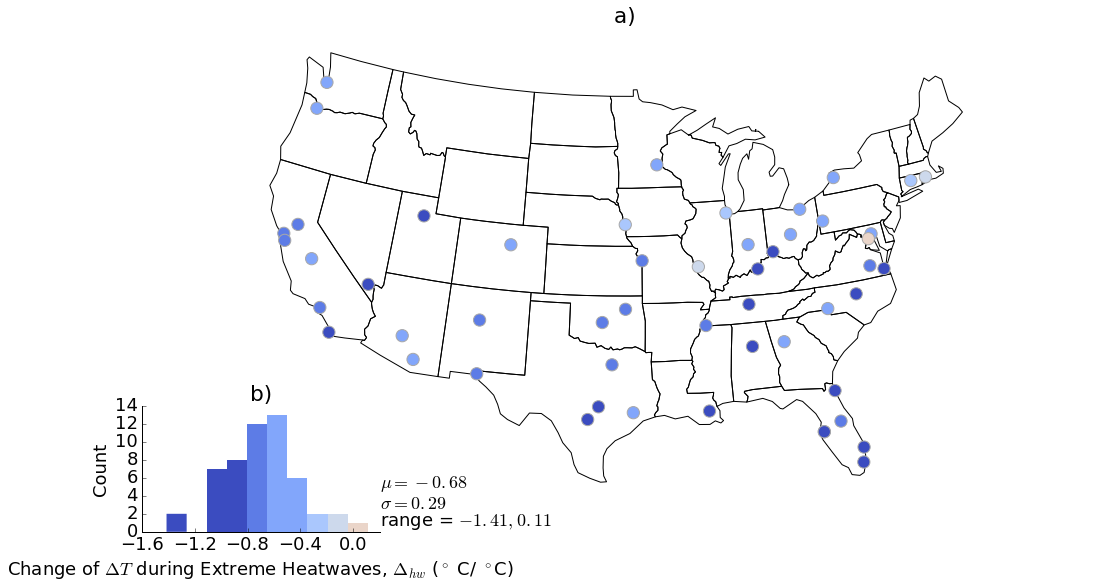

In [163]:
# extreme heatwave sensitivity map
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])#.drop(drop_cities)
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Extreme Heatwaves', 
                    data_label='Change of $\Delta T$ during Extreme Heatwaves, $\Delta_{hw}$ ($^\circ$ C/ $^\circ $C)', 
                ) 
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'extreme_hw_map.pdf', bbox_inches='tight')

In [168]:
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])

In [55]:
compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4]

7.8333333333333348

In [56]:
compositeTempDF.mean(axis=1).argmin()

'Albuquerque'

In [57]:
compositeTempDF.mean(axis=1).argmax()

'Phoenix'

In [58]:
compositeUHIDF.mean() - compositeUHIDF.mean()[-5]

-5    0.000000
-4   -0.044349
-3   -0.248405
-2   -0.272337
-1   -0.489324
 0   -4.659501
 1   -1.304766
 2   -0.762409
 3   -0.712969
 4   -0.298066
 5   -0.130592
dtype: float64

In [59]:
compositeTempDF.mean() - compositeTempDF.mean()[-5]

-5    0.000000
-4    0.305249
-3    0.663975
-2    1.336077
-1    2.429975
 0    6.873858
 1    2.501363
 2    1.199462
 3    0.694046
 4    0.110860
 5    0.009745
dtype: float64

In [60]:
(compositeUHIDF.mean() - compositeUHIDF.mean()[-5])[0] / (compositeTempDF.mean() - compositeTempDF.mean()[-5])[0]

-0.67785823015066893

In [61]:
-4.65/6.87

-0.6768558951965066

In [62]:
(compositeUHIDF[0]< 0).sum()

44

In [63]:
(compositeUHIDF[0]> 0).sum()

9

In [64]:
compositeUHIDF.shape

(53, 11)

In [ ]:
# Plot boxplots of slopes
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
JJAresults = pd.read_csv('plots/version3/US_results_cleaned_data.csv').set_index('City').drop(drop_cities, axis=0)

#cities = paired_df['City'].values
cities = JJAresults.index.values
M_list = []
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        #M_list.append(np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
    except IOError: 
#        M_list.append(np.loadtxt(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
        print('Skipping %s'%city)

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = JJAresults['Slope'].loc[cities]
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$, this study')
ax.axhline(0, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{day}$ ($^\circ$C/$^\circ$C)')
#ax.set_title('Slope of UHI response to Temperature')
plt.ylim([-1., .25])
plt.legend()
plt.savefig(results_filepath+'allcitiesm.pdf', bbox_inches='tight')

In [ ]:
# Plot boxplots of UHI trend range
#results_filepath = 'plots/version2/UHIvariance_brightness_thresh/'
cities = []
M_list = []
for city in combined_cities: 
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrUHIslopes.npy')
        #array = np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        if city =='Arlington': 
            cities.append('Grand Prairie')
        else: 
            cities.append(city)
    except IOError: 
        print('Skipping %s'%city)

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')

X= np.arange(1, len(cities)+1)
Y= mydf.set_index('City')['UHI linear trend'][cities]# mydf['Mean UHI'][cities]
ax.axhline(Y.mean(), color = 'lightgray', label = 'Mean this study')
ax.axhline(0, color = 'black', )
ax.plot( X, Y,'*',#'x', 
        color = 'black', markerSize = 10, label = 'This study')
#ax.axhline(Y.mean(), color = 'black')
ax.plot(X,  ccUHIdf.set_index('City').loc[combined_cities]['UHI trend'],'*',#'x', 
        color = 'green', markerSize = 10, label = 'CC data')
#ax.axhline(ccUHIdf.set_index('City').loc[combined_cities]['UHI trend'].mean(), color = 'green')

ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)

#plt.legend()
ax.set_ylabel('Annual Trend in $\Delta T$ ($^\circ$C/yr)')
ax.set_title('Possible UHI long term trends')
plt.ylim([-0.9, 1.0])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc =1) #loc='upper left', 
                #bbox_to_anchor=(1.0,0.5))
plt.savefig(results_filepath+'allcitiesUHItrend.pdf', bbox_inches='tight')

In [270]:
np.random.random?

(-0.0042316828591843283, -0.061140634494670679, 0.17225254490476657)

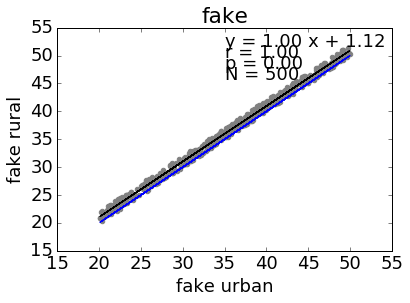

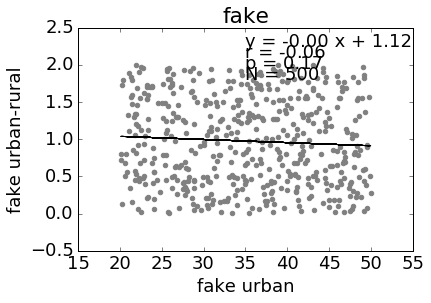

In [286]:
# mock up weather data
A = np.random.random(500)*30+20# dummy interval 20,50 
B = A + np.random.rand(500)*2
hw_scatter(A,B, 'fake','fake urban','fake rural')
plt.plot(A,A)
plt.figure()
hw_scatter(A,B-A, 'fake','fake urban','fake urban-rural')

In [301]:
R = np.zeros([100])
for i in range(0,55):
    A = np.random.random(500)*30+20# dummy interval 20,50 
    B = A + np.random.rand(500)*10
    R[i] = pearsonr_autocorrelated(A, B-A)[0]

In [307]:
R.max()

0.1257606757994808

(0.0012900545965588907, 0.0039907165924316897, 0.92907225785575231)

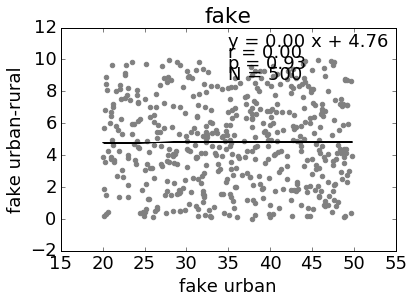

In [284]:
hw_scatter(A,B-A, 'fake','fake urban','fake urban-rural')

In [268]:
urban_summer[rural.shape, rural_summer.shape

((2944,), (2529,))

(0.7325647404610458, 0.72228588873171085, 0.0)

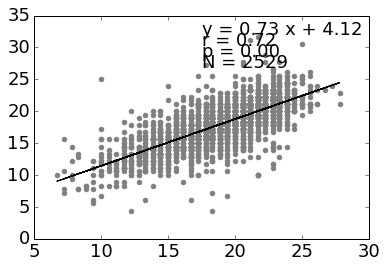

In [269]:
hw_scatter(urban_summer[rural_summer.index], rural_summer, '', '', '')

In [312]:
for i in range(0,15):
    A = np.random.random(500)*30+20# dummy interval 20,50 
    B = A + np.random.rand(500)*10
    print np.cov(A, B)[0,1]- np.var(A)

-0.794364808979
1.27407307141
1.27023330966
0.469485792603
1.15092908732
-0.0934555888362
-0.408964662477
0.811541105073
-1.49181492254
-2.01474224452
-0.0488208048767
-0.138572437994
-1.62269479058
0.952186640568
0.226804560496


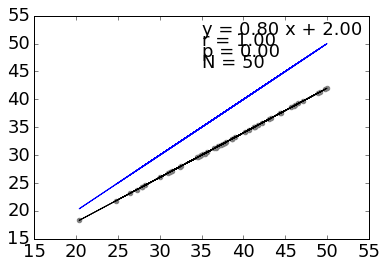

In [318]:
X = np.random.random(50)*30+20
b = 2
a = .8
hw_scatter(X, a*X+b, '', '', '')
plt.plot(X,X)